In [1]:
import random
import torch
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from timeit import default_timer
from scipy.io import loadmat
import yaml
import scipy.linalg.interpolative as sli

sys.path.append("../")


from models import  FNN_train, compute_2dFourier_bases, compute_2dpca_bases, compute_2dFourier_cbases,compute_H, count_params,HGkNN_train

from models.Multi_HGalerkin import Multi_HGkNN

torch.set_printoptions(precision=16)


torch.manual_seed(0)
np.random.seed(0)


def column_selection(datax, datay, x_kmax, y_kmax):
    # x_train : Array[ndata, N]
    # y_train  : Array[ndata, N]
    # pick at most x_kmax points from x_train, and y_kmax from y_train
    x_idx, x_proj = sli.interp_decomp(datax, x_kmax)
    y_idx, y_proj = sli.interp_decomp(datay, y_kmax)
    
    union_idx = list(set(x_idx[0:x_kmax]).union(set(y_idx[0:y_kmax])))
    
    x_proj, _, _, _ = np.linalg.lstsq(datax[:,union_idx], datax)   
    y_proj, _, _, _ = np.linalg.lstsq(datay[:,union_idx], datay)   

    
    return union_idx, x_proj, y_proj
###################################
# load configs
###################################
with open('config.yml', 'r', encoding='utf-8') as f:
    config = yaml.full_load(f)

config = config["test"]
config = dict(config)
config_data, config_model, config_train = (
    config["data"],
    config["model"],
    config["train"],
)
downsample_ratio = config_data["downsample_ratio"]
L = config_data["L"]
n_train = config_data["n_train"]
n_test = config_data["n_test"]
device = torch.device(config["train"]["device"])


###################################
# load data
###################################
data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth1"
data1 = loadmat(data_path)
# data_path = "../data/darcy_2d/piececonst_r421_N1024_smooth2"
# data2 = loadmat(data_path)
# data_in = np.vstack((data1["coeff"], data2["coeff"]))  # shape: 2048,421,421
# data_out = np.vstack((data1["sol"], data2["sol"]))     # shape: 2048,421,421
data_in = data1["coeff"]
data_out = data1["sol"]
print("data_in.shape:" , data_in.shape)
print("data_out.shape", data_out.shape)

Np_ref = data_in.shape[1]
grid_1d = np.linspace(0, L, Np_ref)
grid_x, grid_y = np.meshgrid(grid_1d, grid_1d)

data_in_ds = data_in[0:n_train, 0::downsample_ratio, 0::downsample_ratio]
grid_x_ds = grid_x[0::downsample_ratio, 0::downsample_ratio]
grid_y_ds = grid_y[0::downsample_ratio, 0::downsample_ratio]
data_out_ds = data_out[0:n_train, 0::downsample_ratio, 0::downsample_ratio]

# x_train, y_train are [n_data, n_x, n_channel] arrays
x_train = torch.from_numpy(
    np.stack(
        (
            data_in_ds,
            np.tile(grid_x_ds, (n_train, 1, 1)),
            np.tile(grid_y_ds, (n_train, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_train = torch.from_numpy(data_out_ds[:, :, :, np.newaxis].astype(np.float32))
# x_test, y_test are [n_data, n_x, n_channel] arrays
x_test = torch.from_numpy(
    np.stack(
        (
            data_in[-n_test:, 0::downsample_ratio, 0::downsample_ratio],
            np.tile(grid_x[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
            np.tile(grid_y[0::downsample_ratio, 0::downsample_ratio], (n_test, 1, 1)),
        ),
        axis=-1,
    ).astype(np.float32)
)
y_test = torch.from_numpy(
    data_out[-n_test:, 0::downsample_ratio, 0::downsample_ratio, np.newaxis].astype(
        np.float32
    )
)

x_train = x_train.reshape(x_train.shape[0], -1, x_train.shape[-1])   # shape: 800,11236,3  (11236 = 106*106 , 106-1 = (421-1) /4)
x_test = x_test.reshape(x_test.shape[0], -1, x_test.shape[-1])
y_train = y_train.reshape(y_train.shape[0], -1, y_train.shape[-1])   # shape: 800,11236,1
y_test = y_test.reshape(y_test.shape[0], -1, y_test.shape[-1])
print("x_train.shape: ",x_train.shape)
print("y_train.shape: ",y_train.shape)

###################################
#compute fourier bases
###################################
# k_max = max(config_model["GkNN_modes"])
# Np = (Np_ref + downsample_ratio - 1) // downsample_ratio
# gridx, gridy, fbases, weights = compute_2dFourier_bases(Np, Np, k_max, L, L)
# fbases = fbases.reshape(-1, k_max)
# weights = weights.reshape(-1)
# wfbases = fbases * np.tile(weights, (k_max, 1)).T
# bases_fourier = torch.from_numpy(fbases.astype(np.float32)).to(device)
# wbases_fourier = torch.from_numpy(wfbases.astype(np.float32)).to(device)


####################################
#compute pca bases
####################################


num_inside_points = config_model['num_inside_points']
xy_idx = 0 
x_kmax, y_kmax = num_inside_points, num_inside_points

data_x = x_train[:,:,0].numpy().astype(np.float64)
data_y = y_train[:,:,0].numpy().astype(np.float64)

print("Start Column Selection with data shape: ", data_x.shape,'points number =',num_inside_points)
xy_idx, x_proj, y_proj = column_selection(data_x,data_y , x_kmax, y_kmax)
# x_proj.shape: k , N
x_proj = torch.from_numpy(x_proj).to(x_train.dtype).transpose(0,1).to(device)   # shape: N,k
y_proj = torch.from_numpy(y_proj).to(x_train.dtype).transpose(0,1).to(device)   # shape: N,k



k_max_outside = config_model['outside']["modes"]
k_max_inside = config_model['inside']["modes"]
Np = (Np_ref + downsample_ratio - 1) // downsample_ratio

pca_data_out = data_out_ds.reshape((data_out_ds.shape[0], -1))  #(800, 961)
pca_data_inside_out = pca_data_out[:,xy_idx]

print("Start SVD with data shape: ", pca_data_out.shape, pca_data_inside_out.shape)
bases_pca_out, wbases_pca_out = compute_2dpca_bases(Np , k_max_outside , L,  pca_data_out)
bases_pca_out, wbases_pca_out = bases_pca_out.to(device), wbases_pca_out.to(device)

bases_pca_inside_out, wbases_pca_inside_out = compute_2dpca_bases(Np , k_max_inside , L,  pca_data_inside_out)
bases_pca_inside_out, wbases_pca_inside_out = bases_pca_inside_out.to(device), wbases_pca_inside_out.to(device)

bases_list = [bases_pca_out, wbases_pca_out, bases_pca_inside_out, wbases_pca_inside_out,x_proj]

data_in.shape: (1024, 421, 421)
data_out.shape (1024, 421, 421)
x_train.shape:  torch.Size([800, 5041, 3])
y_train.shape:  torch.Size([800, 5041, 1])
Start Column Selection with data shape:  (800, 5041) points number = 256
Start SVD with data shape:  (800, 5041) (800, 501)


torch.Size([5041, 96]) torch.Size([501, 32])


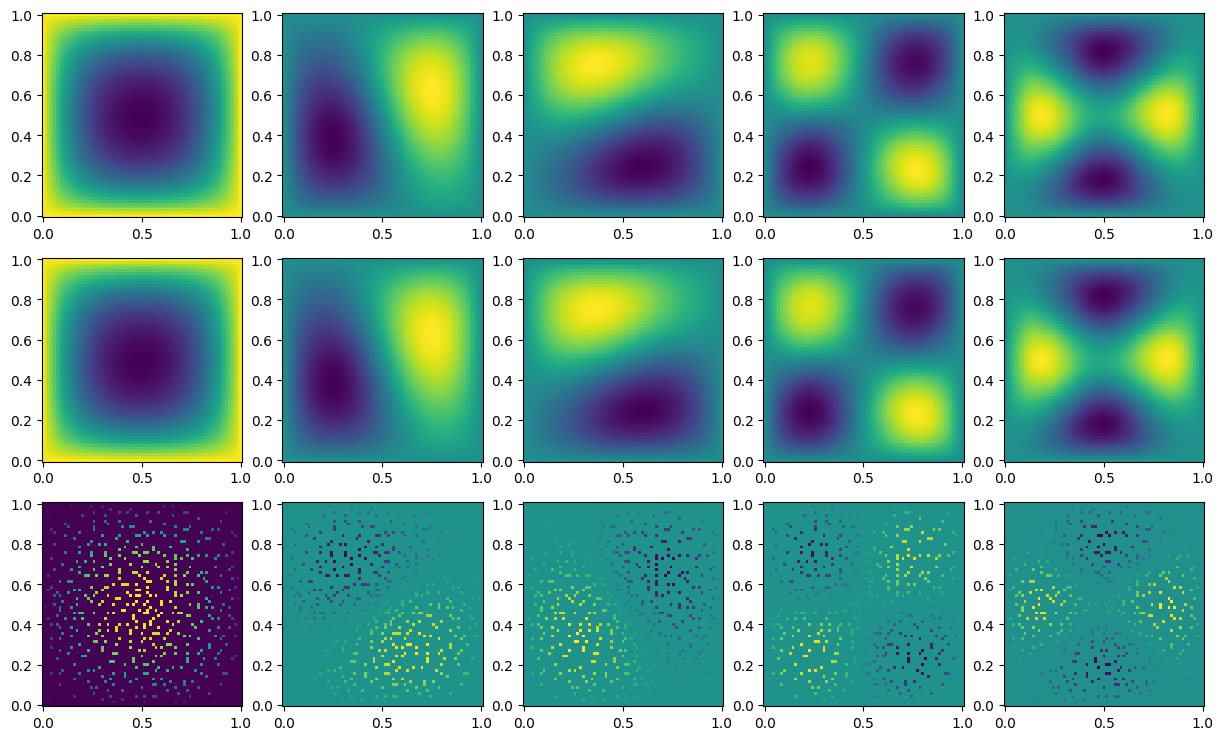

In [6]:
print(bases_pca_out.shape,bases_pca_inside_out.shape)

bases = bases_pca_out.reshape(Np,Np,k_max_outside).to('cpu')
wbases = wbases_pca_out.reshape(Np,Np,k_max_outside).to('cpu')
zeros = torch.zeros(bases_pca_out.shape).numpy()  #torch.Size([5041, 96])
zeros[xy_idx,:k_max_inside] = bases_pca_inside_out.to('cpu')
zeros = zeros[:,:k_max_inside].reshape(Np,Np,k_max_inside)
mygrid = np.linspace(0, L, Np)
grid_x, grid_y = np.meshgrid(mygrid, mygrid)
m=3
n=5
fig, axs = plt.subplots(m, n, figsize=(3*n,3*m))
for i in range(5):
    axs[0,i].pcolormesh(grid_x, grid_y, bases[:,:,i])
    axs[1,i].pcolormesh(grid_x, grid_y, wbases[:,:,i])
    # axs[2,i].pcolormesh(grid_x, grid_y, bases_pca_2d[:,:,i+10])
    # axs[2,i].pcolormesh(grid_x, grid_y, wbases_pca_2d[:,:,i])
    axs[2,i].pcolormesh(grid_x, grid_y, zeros[:,:,i])
    # axs[4,i].pcolormesh(grid_x, grid_y, bases_fourier_2d[:,:,i+5])

# axs[1].pcolormesh(grid_x, grid_y, data_out[0,:,:])